In [2]:
# standard numerical library imports
import numpy as np

# energyflow imports
import energyflow as ef
from energyflow.archs import EFN
from energyflow.datasets import qg_jets
from energyflow.utils import data_split, to_categorical

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

#!pip install github.com/rikab/rikabplotlib.git
from rikabplotlib.plot_utils import newplot, hist_with_outline, hist_with_errors, stamp

2024-10-25 21:29:18.231592: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/home/rikab/miniconda3/envs/SHAPER/lib/python3.8/site-packages/ot/backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


In [36]:
N_jets = 50000*4
R = 0.4
X, y = qg_jets.load(N_jets)
E0 = 500

# Jet only jets with y = 1
X = X[y == 1][:N_jets]

# Preprocess
X = X[:,:,:3]
total_energy = np.sum(X[:,:,0], axis=1)
for x in X:
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

def compute_angularity(X, beta = 1):
    return np.sum(X[:,:,0] * np.power((X[:,:,1]**2 + X[:,:,2]**2),(beta/2)) / np.power(R, beta) , axis=1)




In [37]:
def alpha_s(scale):
    lambda_qcd = 0.2
    beta_0 = 11 - 2/3 * 3
    return 4 * np.pi / (beta_0 * np.log(scale**2 / lambda_qcd**2))

def LO_angularity(lambda_, beta = 1):

    scale = 500 * np.power(lambda_, 1 / (beta))

    alpha_s_scale = alpha_s(scale)
    C_F = 4/3
    C_A = 3

    return -(2 * alpha_s_scale * C_F / (1 * np.pi * beta * R)) * np.log(lambda_ ) / lambda_

def LL_angularity(lambda_, beta = 1):

    scale = 500 * np.power(lambda_, 1 / (beta))

    alpha_s_scale = alpha_s(scale)
    C_F = 4/3
    C_A = 3

    return LO_angularity(lambda_, beta) * np.exp(- 1 * alpha_s_scale * C_F / (beta * R *  np.pi) * np.power(np.log(lambda_), 2))

# # plot alpha_s as a function of scale
# lambdas = np.logspace(0, 2, 100)
# alphas = np.array([alpha_s(l) for l in lambdas])
# plt.plot(lambdas, alphas)



def dalpha_dscale(scale):
    lambda_qcd = 0.2
    beta_0 = 11 - 2/3 * 3
    return -4 * np.pi / beta_0  / (np.log(scale**2 / lambda_qcd**2) ** 2) * 2 / scale




def df_dx(lambda_, beta = 1):

    lambda_qcd = 0.2
    beta_0 = 11 - 2/3 * 3

    scale = E0 * np.power(lambda_, 1 / (beta))
    alpha_s_scale = alpha_s(scale)

    C_F = 4/3


    dLO_dalpha =  -C_F / (beta * R *  np.pi) * np.power(np.log(lambda_), 2)
    dalpha_dscale = -4 * np.pi / beta_0  / (np.log(scale**2 / lambda_qcd**2) ** 2) * 2 / scale
    dscale_dlambda = E0

    return dLO_dalpha * dalpha_dscale * dscale_dlambda


def Theta(x):
    return 0.5 * (np.sign(x) + 1)
   


def LL_exact_angularity(lambda_, beta = 1):

    scale = E0 * np.power(lambda_, 1 / (beta))

    alpha_s_scale = alpha_s(scale)
    C_F = 4/3
    C_A = 3

    p = np.nan_to_num((LO_angularity(lambda_, beta) + df_dx(lambda_, beta)) * np.exp(-1 * alpha_s_scale * C_F / (beta * R *  np.pi) * np.power(np.log(lambda_), 2)) )

    return  (p * Theta(lambda_) * Theta(1 - lambda_)) * 1


3.713611478355496


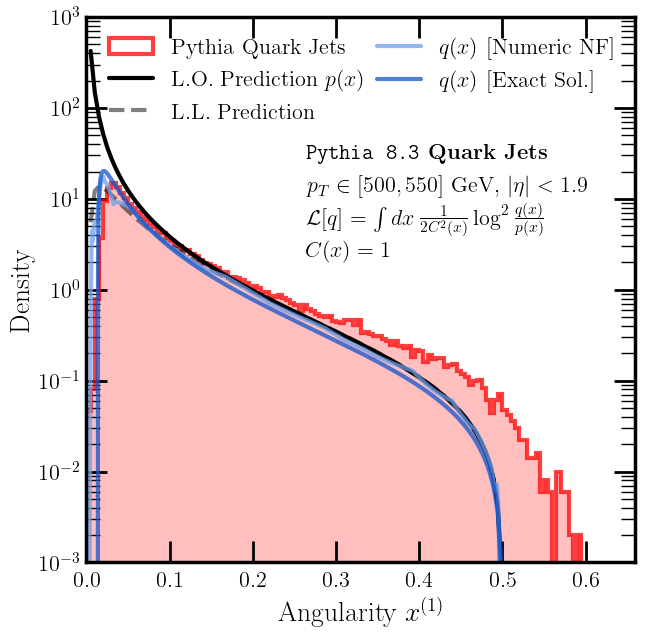

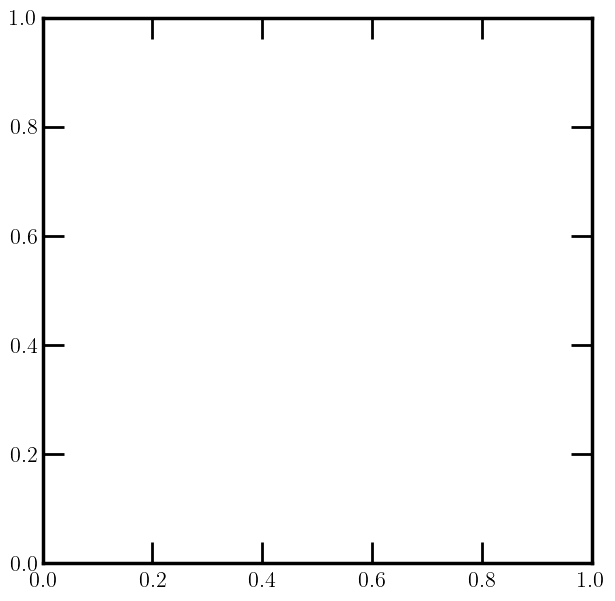

In [41]:
beta = 1
plot_NF = True
plot_exact = True

fig, ax = newplot("full")

normalized_angularity = compute_angularity(X, beta=beta) 
# normalized_angularity = normalized_angularity / np.max(normalized_angularity)
np.save("normalized_angularity.npy", normalized_angularity)
bins, edges = np.histogram(normalized_angularity, bins=100, range=(0,1))

errors = np.sqrt(bins)
total_norm = np.sum(bins) * (edges[1] - edges[0])
bins = bins / total_norm
errors = errors / total_norm 



hist_with_outline(ax, normalized_angularity, bins=200, range=(0,1),  density = True, color = "red", label = "Pythia Quark Jets", lw = 3)
lambdas = np.linspace(0.01, 0.999, 100)

densities = LO_angularity(lambdas, beta = beta)
# densities = np.maximum(0, densities)
# normalize angularities so the integral is 1
print(np.trapz(densities, lambdas))
# densities = densities / np.trapz(densities, lambdas) 
ax.plot(lambdas / 2, densities * 2, color="black", label = "L.O. Prediction $p(x)$")


densities = LL_exact_angularity(lambdas, beta = beta)
ax.plot(lambdas / 2, densities * 2, color="black", alpha = 0.5, label = "L.L. Prediction", ls = "--", lw = 3)



if plot_NF:

    color = "#6d9eeb"

    xy = np.load("plotfiles/theta_ys_0.0.npy")

    plt.plot(xy[0] / 2, xy[1] * 2, color=color, label="$q(x)$ [Numeric NF]", lw=3, alpha = 0.75)


if plot_exact:

    color = "#1155cc"
    # color = "0A7DA4"

    xy = np.load("plotfiles/exact_theta_ys_0.0.npy")

    plt.plot(xy[0] / 2, xy[1] * 2, color=color, label="$q(x)$ [Exact Sol.]", lw=3, alpha = 0.75)




plt.xlabel("Angularity $x^{(1)}$")
plt.ylabel("Density")
plt.yscale("log")


line_0 = r"\texttt{Pythia 8.3} Quark Jets"
line_1 = r"$p_T \in [500, 550]$ GeV, $|\eta| < 1.9$"
line_2 = r"$\mathcal{L}[q] = \int dx\, \frac{1}{2C^2(x)}\log^2\frac{q(x)}{p(x)}$"
line_3 = r"$C(x) = 1$"
stamp(0.4, 0.75, ax, line_0 = line_0, line_1 = line_1, line_2 = line_2, line_3 = line_3, textops_update={"fontsize": 16})

# # add verticle line at 0.8
# plt.axvline(0.9, color="grey", linestyle="--")

# # to the left of 0.8, fill in the area
# ax.fill_betweenx([0, 1e3], 0, 0.1, color="blue", alpha=0.1)
# ax.fill_betweenx([0, 1e3], 0.4, 0.6, color="blue", alpha=0.1)
# plt.text(0.075, 0.8, "Not well-modeled", color="blue", rotation=90, va="center", ha="center")

# # to the right of 0.8, fill in the area
# ax.fill_betweenx([0, 1e3], 0.1, 0.4, color="red", alpha=0.1)
# plt.text(0.125, 0.8, "Well-modeled", color="red", rotation=90, va="center", ha="center")


plt.ylim(1e-3, 1e3)
plt.xlim(0, 0.66)
plt.legend(frameon=False, loc="upper right", ncol = 2, fontsize=16, columnspacing=0.5)

plt.savefig("angularity_prediction.pdf")

fig, ax = newplot("full")




# Errorband Plots

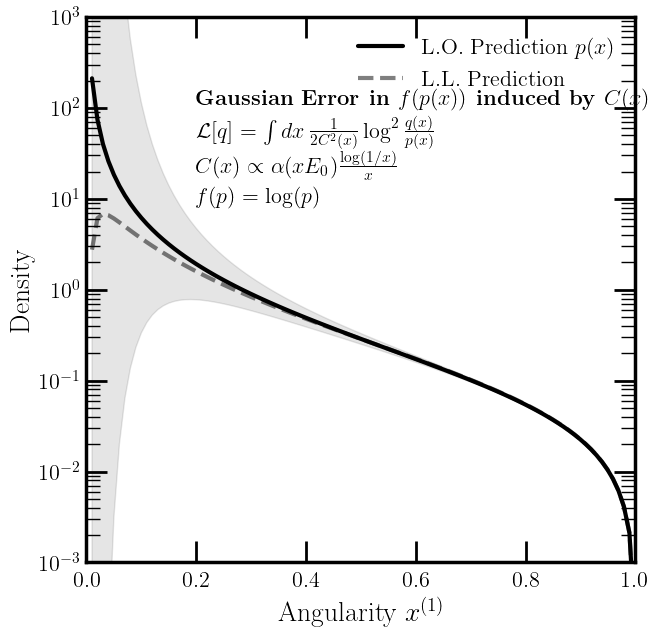

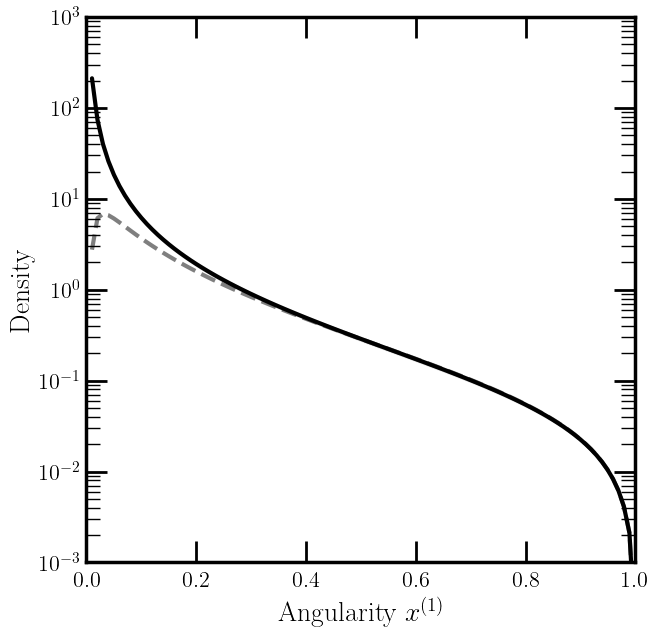

In [87]:

def inverse_variance(x):
    
    return 1 / (2 * alpha_s(E0 * x)**2 * np.log(x)**2 / x**2) * 100

# def inverse_variance(x):

#     sigmoid = lambda x: 1 / (1 + np.exp(-x))
    
#     return sigmoid((x - 0.5) / 0.001) / 0.0001



fig, ax = newplot("full")


# Original LO
y = LO_angularity(lambdas, beta = beta)
ax.plot(lambdas, y, color="black", label = "L.O. Prediction $p(x)$")


# LL for comparison
densities = LL_exact_angularity(lambdas, beta = beta)
ax.plot(lambdas, 
densities, color="black", alpha = 0.5, label = "L.L. Prediction", ls = "--", lw = 3)

# Use the inverse variance as a band on the LO prediction
std = 10 / np.sqrt(2 * inverse_variance(lambdas))
ax.fill_between(lambdas, np.maximum(np.exp(np.log(y) - std), y / 1000000), np.minimum(np.exp(np.log(y) + std), y * 1000000), color="black", alpha=0.1)


plt.xlim(0, 1)
plt.ylim(1e-3, 1e3)
plt.xlabel("Angularity $x^{(1)}$")
plt.ylabel("Density")
plt.yscale("log")


line_0 = r"Gaussian Error $C(x)$ in $f(p(x))$"
line_1 = r"$\mathcal{L}[q] = \int dx\, \frac{1}{2C^2(x)}\log^2\frac{q(x)}{p(x)}$"
line_2 = r"$C(x) \propto \alpha(x E_0) \frac{\log(1/x)}{x}$"
line_3 = r"$f(p) = \log(p)$"
stamp(0.2, 0.85, ax, line_0 = line_0, line_1 = line_1, line_2 = line_2, line_3 = line_3, textops_update={"fontsize": 16})

plt.legend(frameon=False, loc="upper right", fontsize=16)



# Linear 
fig, ax = newplot("full")


# Original LO
y = LO_angularity(lambdas, beta = beta)
ax.plot(lambdas, y, color="black", label = "L.O. Prediction $p(x)$")


# LL for comparison
densities = LL_exact_angularity(lambdas, beta = beta)
ax.plot(lambdas, 
densities, color="black", alpha = 0.5, label = "L.L. Prediction", ls = "--", lw = 3)

# Use the inverse variance as a band on the LO prediction
std = 1 / np.sqrt(2 * inverse_variance(lambdas))
ax.fill_between(lambdas, y - std, y + std, color="black", alpha=0.1)



plt.xlim(0, 1)
plt.ylim(1e-3, 1e3)
plt.xlabel("Angularity $x^{(1)}$")
plt.ylabel("Density")
plt.yscale("log")


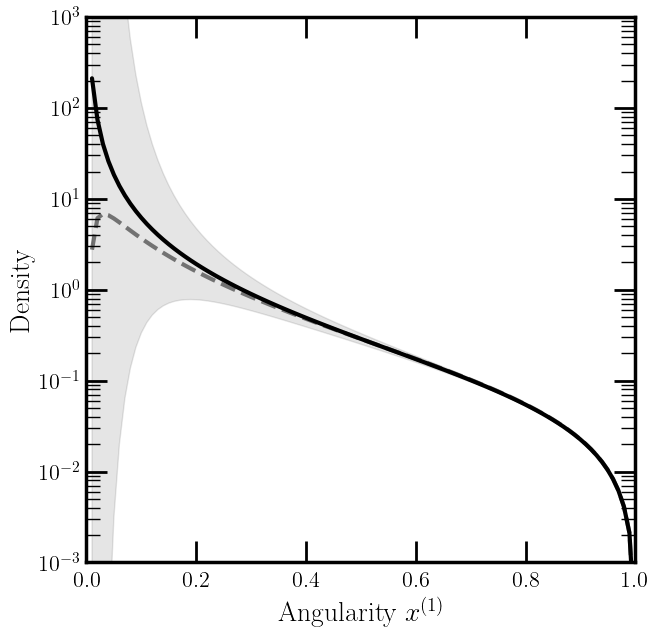